# 📝 Text super-resolution
* team name and members: Super-girls, **Agata Żywot 148258, Zuzanna Gawrysiak 148255**
* selected problem and dataset: Super-resolution, [TextZoom](https://paperswithcode.com/dataset/textzoom)

In [5]:
# LIBRARIES
import cv2
import PIL
import numpy as np
from IPython.display import display

# LOCAL MODULES
from src.mdb_to_jpg2 import *
from src.utils import *

In [2]:
data_path = 'data/TextZoom/train2_img/'
lmdb_file = 'data/TextZoom/train2'
N = mdb_to_jpg(data_path, lmdb_file)

Number of samples: 2794


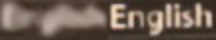

In [33]:
# DISPLAY EXEMPLARY IMAGES
x = 10

imgHR = cv2.imread(data_path+str(x)+'_img_HR.jpg', 1)
imgLR = cv2.imread(data_path+str(x)+'_img_LR.jpg', 1)

if imgHR.shape == imgLR.shape:
    
    imshow(cv2.resize(np.concatenate([imgLR, imgHR],1), None, fx=2, fy=2))

else:
    imshow(cv2.resize(imgLR, None, fx=2, fy=2))
    imshow(cv2.resize(imgHR, None, fx=2, fy=2))